In [2]:
# Basic

import warnings
warnings.filterwarnings('ignore')

import os
from os import makedirs # make directory
from os import listdir # list directories
from shutil import copyfile
from random import seed
from random import random
import numpy as np
import pandas as pd
import cv2

# visuals
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread # Used to read images
from PIL import Image # Image Visulization

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay

# Tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

In [9]:
# Đường dẫn đến thư mục chứa hình ảnh
image_folder = r"C:\Users\Admin\Documents\DPL302m\Kaggle competition\Flood Data\devset_images"

# Đường dẫn đến tệp CSV
csv_file = r'C:\Users\Admin\Documents\DPL302m\Kaggle competition\Flood Data\devset_images_gt.csv'  

# Đọc tệp CSV chứa tên hình ảnh và nhãn
df_csv = pd.read_csv(csv_file)

# Xác minh đường dẫn đầy đủ và tính nhất quán
df_csv['full_path'] = image_folder + '/' + df_csv['id'].astype(str)  # Tạo đường dẫn đầy đủ


- Label 0 : no flood
- Label 1 : flood

In [10]:
# Tạo một hàm để ánh xạ nhãn
def map_label_to_binary(label):
    if label == 0:
        return 'non-flood'
    elif label == 1:
        return 'flood'
    else:
        return None  # Trường hợp nhãn không xác định

# Áp dụng hàm ánh xạ vào cột 'label' và tạo cột 'labels'
df_csv['label'] = df_csv['label'].apply(map_label_to_binary)

# In ra một số dòng đầu của DataFrame sau khi thêm cột 'labels'
df_csv.head()


id      label                                          full_path
0  3519864665  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
1  4896119055  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
2  3468473862  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
3  4120853942  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
4  4436083254  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...

In [11]:
# Kiểm tra sự nhất quán giữa tên tệp trong thư mục và các giá trị trong cột 'id'
files_in_folder = os.listdir(image_folder)
df_csv = df_csv[~df_csv['id'].isin(files_in_folder)]

df_csv

id      label                                          full_path
0     3519864665  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
1     4896119055  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
2     3468473862  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
3     4120853942  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
4     4436083254  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
...          ...        ...                                                ...
5275  8119782888  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
5276  6093294301      flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
5277  6791185487  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
5278  9144682941  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
5279   596012254  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...

[5280 rows x 3 columns]

## Visualize images and labels

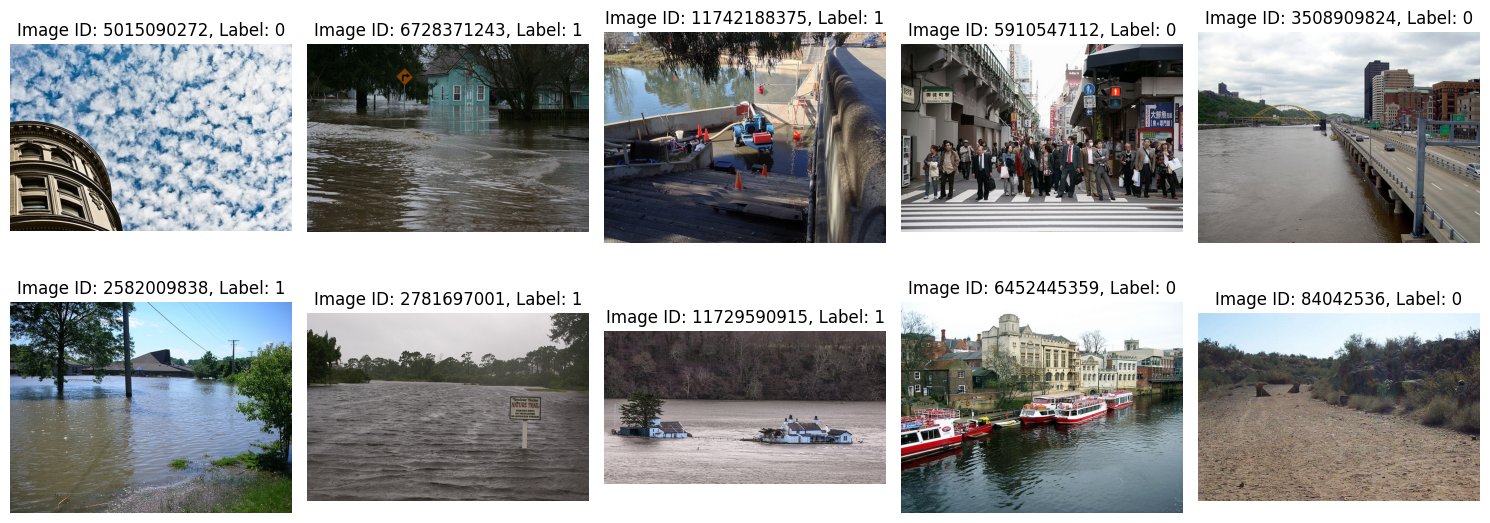

In [23]:
# Số lượng hàng và cột trong lưới
num_rows = 2
num_cols = 5
num_images_to_check = num_rows * num_cols

# Lấy một mẫu ngẫu nhiên từ DataFrame
random_sample = df_csv.sample(n=num_images_to_check)

# Tạo lưới
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

# Lặp qua mỗi hình ảnh trong mẫu ngẫu nhiên
for i, (_, row) in enumerate(random_sample.iterrows()):
    # Lấy đường dẫn đầy đủ từ DataFrame
    image_path = row['full_path']
    
    # Kiểm tra xem hình ảnh có tồn tại không
    if os.path.exists(image_path + '.jpg'):
        image_path = image_path + '.jpg'
    elif os.path.exists(image_path + '.png'):
        image_path = image_path + '.png'
    else:
        print(f"Không tìm thấy hình ảnh tại đường dẫn: {image_path}")
        continue

    # Đọc hình ảnh từ đường dẫn đầy đủ và hiển thị nó
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Chuyển đổi sang định dạng mà matplotlib hiểu được
    
    # Lấy thông tin từ cột 'id' và 'label'
    image_id = row['id']
    label = row['label']
    
    # Tính toán vị trí trong lưới
    row = i // num_cols
    col = i % num_cols
    
    # Hiển thị hình ảnh và thông tin trong ô lưới tương ứng
    axes[row, col].imshow(image)
    axes[row, col].set_title(f"Image ID: {image_id}, Label: {label}")
    axes[row, col].axis('off')

# Hiển thị lưới
plt.tight_layout()
plt.show()


## Visualize the countplot of the data

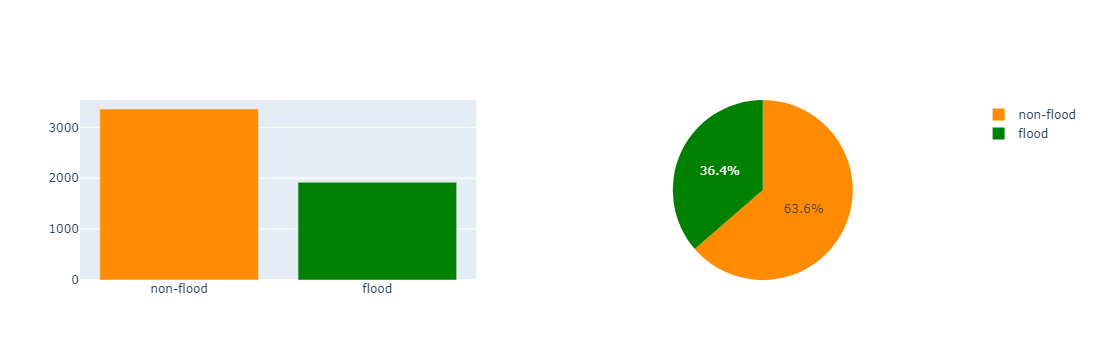

In [25]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

fig = make_subplots(rows=1, cols=2, specs=[[{"type": "xy"}, {"type": "pie"}]])


fig.add_trace(go.Bar(x =df_csv['labels'].value_counts().index,y=df_csv['labels'].value_counts().to_numpy(),marker_color=['darkorange','green'],showlegend=False),row=1,col=1)

fig.add_trace(go.Pie(
     values=dff['labels'].value_counts().to_numpy(),
     labels=dff['labels'].value_counts().index,
    marker=dict(colors=['darkorange','green'])),
    row=1, col=2)

- Flood has 1920 images
- No Flood has 3360 images
  #### Flood labels have less number of images. The data set is imbalanced

## Visualizing the images with flood

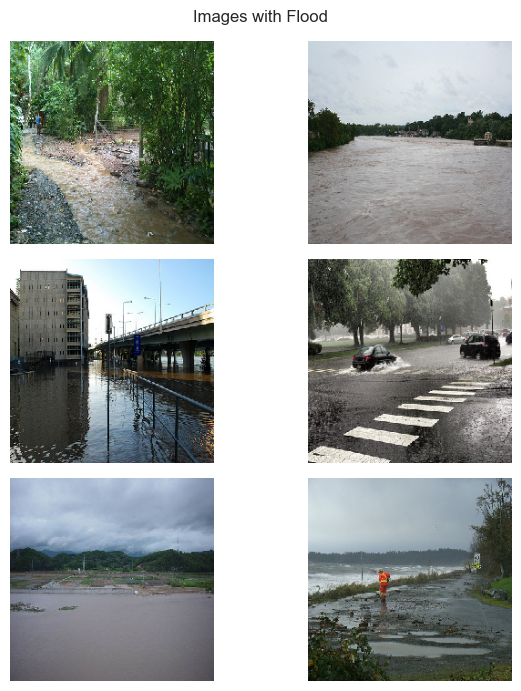

In [26]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
import seaborn as sns

label = 'flood'  # Nhãn cho hình ảnh lũ lụt
data = df_csv[df_csv['labels'] == label]
sns.set_style('dark')

pics = 6  # Số lượng hình ảnh
fig, ax = plt.subplots(int(pics // 2), 2, figsize=(7, 7))
plt.suptitle('Images with Flood')
ax = ax.ravel()

for i in range(pics):
    path = data.sample(1)['full_path'].iloc[0]  # Lấy đường dẫn ngẫu nhiên từ dữ liệu
    path_with_extension = path + '.jpg'  # Thêm phần mở rộng .jpg vào đường dẫn
    img = image.load_img(path_with_extension, target_size=(224, 224))  # Load hình ảnh với kích thước đã chọn
    img = image.img_to_array(img) / 255.0  # Chuyển đổi hình ảnh thành mảng numpy và chuẩn hóa
    ax[i].imshow(img)
    ax[i].axis('off')

plt.tight_layout()
plt.show()


## Visualizing the images with not flood

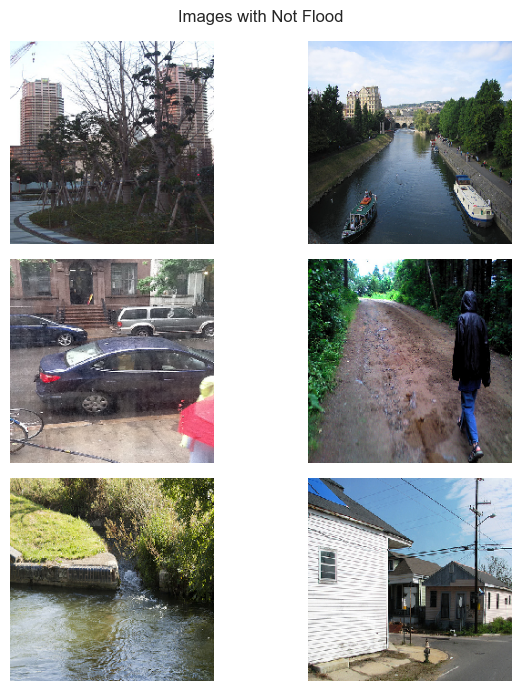

In [27]:
import matplotlib.pyplot as plt
from keras.preprocessing import image
import seaborn as sns

label = 'non-flood'  # Nhãn cho hình ảnh lũ lụt
data = df_csv[df_csv['labels'] == label]
sns.set_style('dark')

pics = 6  # Số lượng hình ảnh
fig, ax = plt.subplots(int(pics // 2), 2, figsize=(7, 7))
plt.suptitle('Images with Not Flood')
ax = ax.ravel()

for i in range(pics):
    path = data.sample(1)['full_path'].iloc[0]  # Lấy đường dẫn ngẫu nhiên từ dữ liệu
    path_with_extension = path + '.jpg'  # Thêm phần mở rộng .jpg vào đường dẫn
    img = image.load_img(path_with_extension, target_size=(224, 224))  # Load hình ảnh với kích thước đã chọn
    img = image.img_to_array(img) / 255.0  # Chuyển đổi hình ảnh thành mảng numpy và chuẩn hóa
    ax[i].imshow(img)
    ax[i].axis('off')

plt.tight_layout()
plt.show()


## Visualize the distribution of their shapes

In [13]:
from keras.preprocessing import image

def shaper(row):
    path_with_extension = row['full_path'] + '.jpg'  # Thêm phần mở rộng .jpg vào đường dẫn
    try:
        shape = image.load_img(path_with_extension).size  # Thử load hình ảnh
        row['height'] = shape[1]  # Gán chiều cao
        row['width'] = shape[0]  # Gán chiều rộng
    except FileNotFoundError:
        # Nếu không tìm thấy tệp hình ảnh, gán chiều cao và chiều rộng là None
        row['height'] = None
        row['width'] = None
    return row

# Áp dụng hàm shaper vào từng dòng của DataFrame dff
dff_shape = df_csv.apply(shaper, axis=1)

dff_shape.head()


id      label                                          full_path  \
0  3519864665  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...   
1  4896119055  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...   
2  3468473862  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...   
3  4120853942  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...   
4  4436083254  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...   

   height  width  
0   333.0  500.0  
1   500.0  332.0  
2   500.0  375.0  
3   375.0  500.0  
4   375.0  500.0

In [12]:
# Xoá cột 'id' từ DataFrame
df_csv.drop(columns=['id'], inplace=True)

# Gán kết quả vào biến mới nếu cần
dff = df_csv.copy()


In [13]:
dff.sample(10)

label                                          full_path
502       flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
382   non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
1549      flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
2131  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
1125      flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
5212      flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
2729  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
4306  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
49    non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
4036      flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...

In [14]:
# train test split using dataframe

labels = dff['label']

# 20% split
# 80%.    20%
X_train, X_temp = train_test_split(dff, test_size=0.2, stratify=labels, random_state = 42)

label_test_val = X_temp['label']

# 10%.   10%
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

print('The shape of train data',X_train.shape) # 80%
print('The shape of test data',X_test.shape) # 10%
print('The shape of validation data',X_val.shape) #10%

The shape of train data (4224, 2)
The shape of test data (528, 2)
The shape of validation data (528, 2)


In [19]:
labels.value_counts()

label
non-flood    3360
flood        1920
Name: count, dtype: int64

In [21]:
label_test_val

2254    non-flood
2642        flood
3210    non-flood
4351    non-flood
4947        flood
          ...    
5257    non-flood
1976        flood
5053    non-flood
2877    non-flood
1186    non-flood
Name: label, Length: 1056, dtype: object

In [22]:
# Xác định các giá trị duy nhất trong cột 'label'
unique_labels = label_test_val.unique()

# Đếm số lượng giá trị duy nhất
num_unique_labels = len(unique_labels)

# In ra các giá trị duy nhất và số lượng giá trị duy nhất
print("Các giá trị duy nhất trong cột 'label':", unique_labels)
print("Số lượng giá trị duy nhất trong cột 'label':", num_unique_labels)

Các giá trị duy nhất trong cột 'label': ['non-flood' 'flood']
Số lượng giá trị duy nhất trong cột 'label': 2


In [121]:
print(dff.info())
print(dff['labels'].dtype)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5280 entries, 0 to 5279
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   full_path  5280 non-null   object
 1   labels     5280 non-null   object
dtypes: object(2)
memory usage: 82.6+ KB
None
object


In [15]:
X_train

label                                          full_path
3572  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
4765      flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
3171  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
5122  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
2863  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
...         ...                                                ...
2941  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
3639  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
1368  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
185       flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
1503  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...

[4224 rows x 2 columns]

In [39]:
X_test.shape

(528, 2)

In [25]:
X_val

label                                          full_path
489       flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
3995      flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
2681  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
1671  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
3835  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
...         ...                                                ...
2262  non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
376       flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
5055      flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
463   non-flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...
3589      flood  C:\Users\Admin\Documents\DPL302m\Kaggle compet...

[528 rows x 2 columns]

# Image Generation or Augmentation

In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [18]:
generator = ImageDataGenerator(
    rotation_range= 20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 2,
    zoom_range=0.2,
    rescale = 1/255,
    validation_split=0.2,
)

In [19]:
# parameters
image_size = 256 # Size of the image
image_channel = 3 # Colour scale (RGB)
bat_size = 32 # Number of files/images processed at onc

In [20]:
# Creating image data generator
# Preprocess images ==> Feature Engineering for Images
train_datagen = generator

test_datagen = generator

In [21]:
import os

# Assuming all images are .jpg
image_extension = '.jpg'

# Correct the base path
base_path = r'C:\Users\Admin\Documents\DPL302m\Kaggle competition\Flood Data\devset_images'

# Function to correct paths
def correct_path(filename):
    return os.path.join(base_path, filename + image_extension)

# Apply the correction
X_train['full_path'] = X_train['full_path'].apply(lambda x: correct_path(os.path.basename(x)))
X_val['full_path'] = X_val['full_path'].apply(lambda x: correct_path(os.path.basename(x)))
X_test['full_path'] = X_test['full_path'].apply(lambda x: correct_path(os.path.basename(x)))

# Verify the corrected paths
for path in X_train['full_path'].head():
    if not os.path.isfile(path):
        print(f"File not found: {path}")


In [22]:
# Applying image data gernerator to train and test data

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = r"C:\Users\Admin\Documents\DPL302m\Kaggle competition\Flood Data\devset_images",
                                                    x_col= 'full_path',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )
val_generator = test_datagen.flow_from_dataframe(X_val, 
                                                 directory = r'C:\Users\Admin\Documents\DPL302m\Kaggle competition\Flood Data\devset_images',
                                                 x_col= 'full_path',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test, 
                                                  directory = r'C:\Users\Admin\Documents\DPL302m\Kaggle competition\Flood Data\devset_images',
                                                  x_col= 'full_path',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 4214 validated image filenames belonging to 2 classes.
Found 526 validated image filenames belonging to 2 classes.
Found 525 validated image filenames belonging to 2 classes.


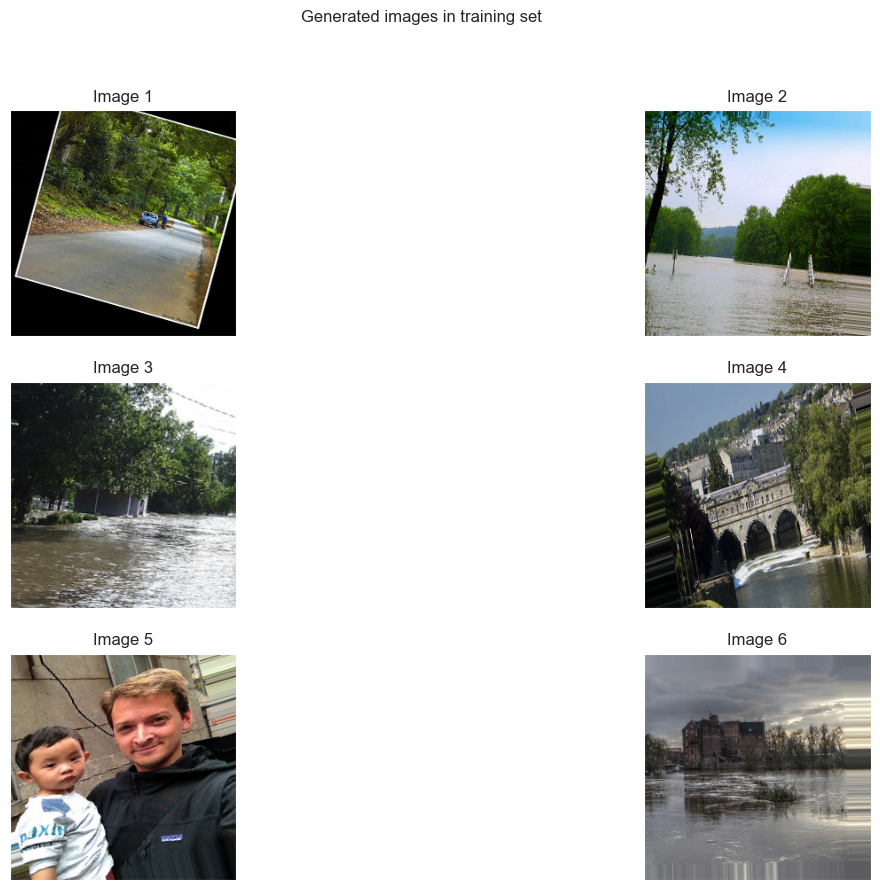

In [70]:
import matplotlib.pyplot as plt

sns.set_style('dark')
pics = 6  # set the number of pics
fig, ax = plt.subplots(int(pics // 2), 2, figsize=(15, 10))
plt.suptitle('Generated images in training set')
ax = ax.ravel()
for i in range((pics // 2) * 2):
    img = train_generator[0][0][i]
    ax[i].imshow(img)
    ax[i].axes.xaxis.set_visible(False)
    ax[i].axes.yaxis.set_visible(False)
    ax[i].set_title(f'Image {i+1}')  # Add a title for each image
plt.show()


# Model 1:

In [72]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
model.add(MaxPooling2D(pool_size=(2,2)))

# Block 1 
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

# Fully Connected layers 
model.add(Flatten())
model.add(Dense(512,activation='relu'))

# Output layer
model.add(Dense(2,activation='softmax')) # Softmax for binary classification

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   125,960,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,981,122 (480.58 MB)

 Trainable params: 125,981,122 (480.58 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 2,restore_best_weights=True,verbose=0)

In [74]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [75]:
history1 = model.fit(train_generator,
                    validation_data = val_generator, 
                    callbacks=[learning_rate_reduction],
                    epochs = 10,
                    # steps_per_epoch = len(train_generator),
                    # validation_steps = len(val_generaotor),
                   )

Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 562s 4s/step - accuracy: 0.6489 - loss: 2.8290 - val_accuracy: 0.7186 - val_loss: 0.5575 - learning_rate: 0.0010
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 534s 4s/step - accuracy: 0.7223 - loss: 0.5425 - val_accuracy: 0.6882 - val_loss: 0.5689 - learning_rate: 0.0010
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 488s 4s/step - accuracy: 0.7109 - loss: 0.5621 - val_accuracy: 0.7414 - val_loss: 0.5195 - learning_rate: 0.0010
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 512s 4s/step - accuracy: 0.7339 - loss: 0.5237 - val_accuracy: 0.7624 - val_loss: 0.5176 - learning_rate: 0.0010
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 566s 4s/step - accuracy: 0.7429 - loss: 0.5198 - val_accuracy: 0.7510 - val_loss: 0.5092 - learning_rate: 0.0010
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7543 - loss: 0.4990
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
132/132 ━━━━━━━━━━━━━━━━━━━━ 484s 4s/step - accuracy: 0.7543 - loss: 0.499

In [76]:
history1.history

{'accuracy': [0.6945169568061829,
  0.7227628827095032,
  0.7215760946273804,
  0.7353429794311523,
  0.7500593662261963,
  0.7495846152305603,
  0.7569428086280823,
  0.7657251358032227,
  0.7709470391273499,
  0.7711844444274902],
 'loss': [1.129347801208496,
  0.5416083335876465,
  0.544982373714447,
  0.5263827443122864,
  0.514715313911438,
  0.5105005502700806,
  0.4944818317890167,
  0.4805053472518921,
  0.46918949484825134,
  0.4658256471157074],
 'val_accuracy': [0.7186312079429626,
  0.6882129311561584,
  0.7414448857307434,
  0.7623574137687683,
  0.7509505748748779,
  0.7091254591941833,
  0.7832699418067932,
  0.76615971326828,
  0.7585551142692566,
  0.7775665521621704],
 'val_loss': [0.5574994087219238,
  0.5689160823822021,
  0.5194708704948425,
  0.5175507664680481,
  0.5091829299926758,
  0.5555370450019836,
  0.4596600830554962,
  0.48909375071525574,
  0.4851635694503784,
  0.47144192457199097],
 'learning_rate': [0.0010000000474974513,
  0.0010000000474974513,
  0

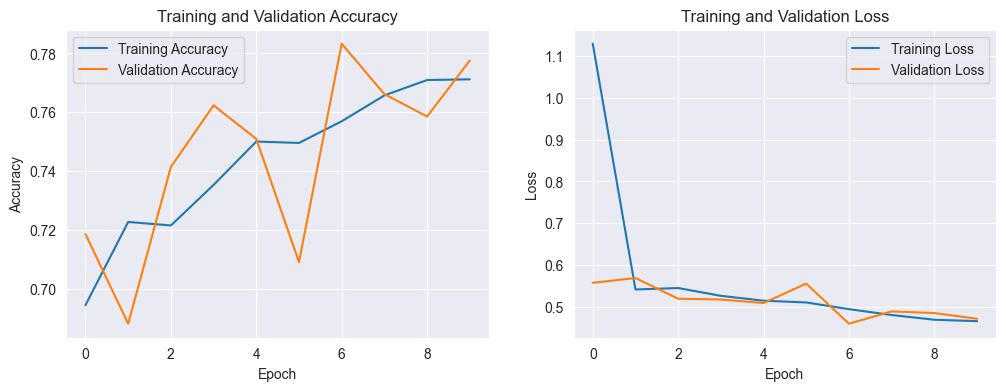

In [78]:
# Plotting the training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [83]:
# Evaluate for train generator
loss,acc = model.evaluate(train_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 77.6643693447113
The Loss of the model for training data is: 0.4594195485115051
The accuracy of the model for validation data is: 78.7072241306305
The Loss of the model for validation data is: 0.4654284119606018


# Model 2:

In [23]:
model2 = Sequential()

# Input Layer
model2.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel))) 
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

# Block 1 
model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

# Fully Connected layers 
model2.add(Flatten())
model2.add(Dense(512,activation='relu'))
model2.add(BatchNormalization())

# Output layer
model2.add(Dense(2,activation='softmax')) # Softmax for binary classification

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 254, 254, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 125, 125, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 246016)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   125,960,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,983,554 (480.59 MB)

 Trainable params: 125,982,338 (480.58 MB)

 Non-trainable params: 1,216 (4.75 KB)

In [25]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 2,restore_best_weights=True,verbose=0)

In [27]:
model2.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [28]:
history2 = model2.fit(train_generator,
                    validation_data = val_generator, 
                    callbacks=[learning_rate_reduction],
                    epochs = 15,
                    # steps_per_epoch = len(train_generator),
                    # validation_steps = len(val_generaotor),
                   )

Epoch 1/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 649s 5s/step - accuracy: 0.6775 - loss: 1.2000 - val_accuracy: 0.6578 - val_loss: 0.6319 - learning_rate: 0.0010
Epoch 2/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 599s 5s/step - accuracy: 0.7509 - loss: 0.5131 - val_accuracy: 0.7110 - val_loss: 0.6019 - learning_rate: 0.0010
Epoch 3/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 600s 5s/step - accuracy: 0.7602 - loss: 0.4948 - val_accuracy: 0.6141 - val_loss: 0.6748 - learning_rate: 0.0010
Epoch 4/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 659s 5s/step - accuracy: 0.7658 - loss: 0.4878 - val_accuracy: 0.7395 - val_loss: 0.5235 - learning_rate: 0.0010
Epoch 5/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 670s 5s/step - accuracy: 0.7965 - loss: 0.4469 - val_accuracy: 0.7433 - val_loss: 0.5102 - learning_rate: 0.0010
Epoch 6/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 634s 5s/step - accuracy: 0.7808 - loss: 0.4503 - val_accuracy: 0.6749 - val_loss: 0.6056 - learning_rate: 0.0010
Epoch 7/15
132/132 ━━━━━━━━━━━━━━━━━━━━ 681s 5s/step - accuracy: 0.7731 - loss: 0.

KeyboardInterrupt: 